# Network Visualization

In [5]:
# Define custom names
custom_names_dict = {
    "Anxiety": {
        -1: "Sleep & Panic",
        0: "Workplace Stress",
        1: "Emotional Identity",
        2: "Social Anxiety",
        3: "Health Anxiety",
        4: "Community Support",
        5: "Medication Effects",
        6: "Workplace Bullying",
        7: "Mindfulness Practice",
        8: "Derealisation States",
        9: "Family Conflict",
        10: "Health Appointments",
        11: "Emotional Uncertainty",
        12: "Family Living"
    },
    "Depression": {
        -1: "Emotional Confusion",
        0: "Family Sadness",
        1: "Negative Emotions",
        2: "Seeking Support",
        3: "Inner Conflict",
        4: "Victim Identity",
        5: "Financial Stress",
        6: "Sleep Disruption"
    },
    "PTSD and trauma": {
        -1: "Childhood Grief",
        0: "Emotional Resilience",
        1: "Abuse Trauma",
        2: "Help Skepticism",
        3: "Nightmare Symptoms",
        4: "Holiday Triggers",
        5: "Support Volunteering",
        6: "Trauma Therapy",
        7: "Sexual Abuse",
        8: "Exposure Therapy",
        9: "Healing Memories",
        10: "Appearance Concerns"
    },
    "Suicidal thoughts and self-harm": {
        -1: "Suicidal Thoughts",
        0: "Work Coping",
        1: "Help-Seeking",
        2: "Emotional Overload",
        3: "Family Trauma",
        4: "Financial Strain",
        5: "Panic & ADHD",
        6: "Family Dysfunction",
        7: "Emotional Emptiness"
    }
}

d:\miniconda3\envs\MDS1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\user\AppData\Local\Temp\ipykernel_29672\2154467046.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10", len(labels))


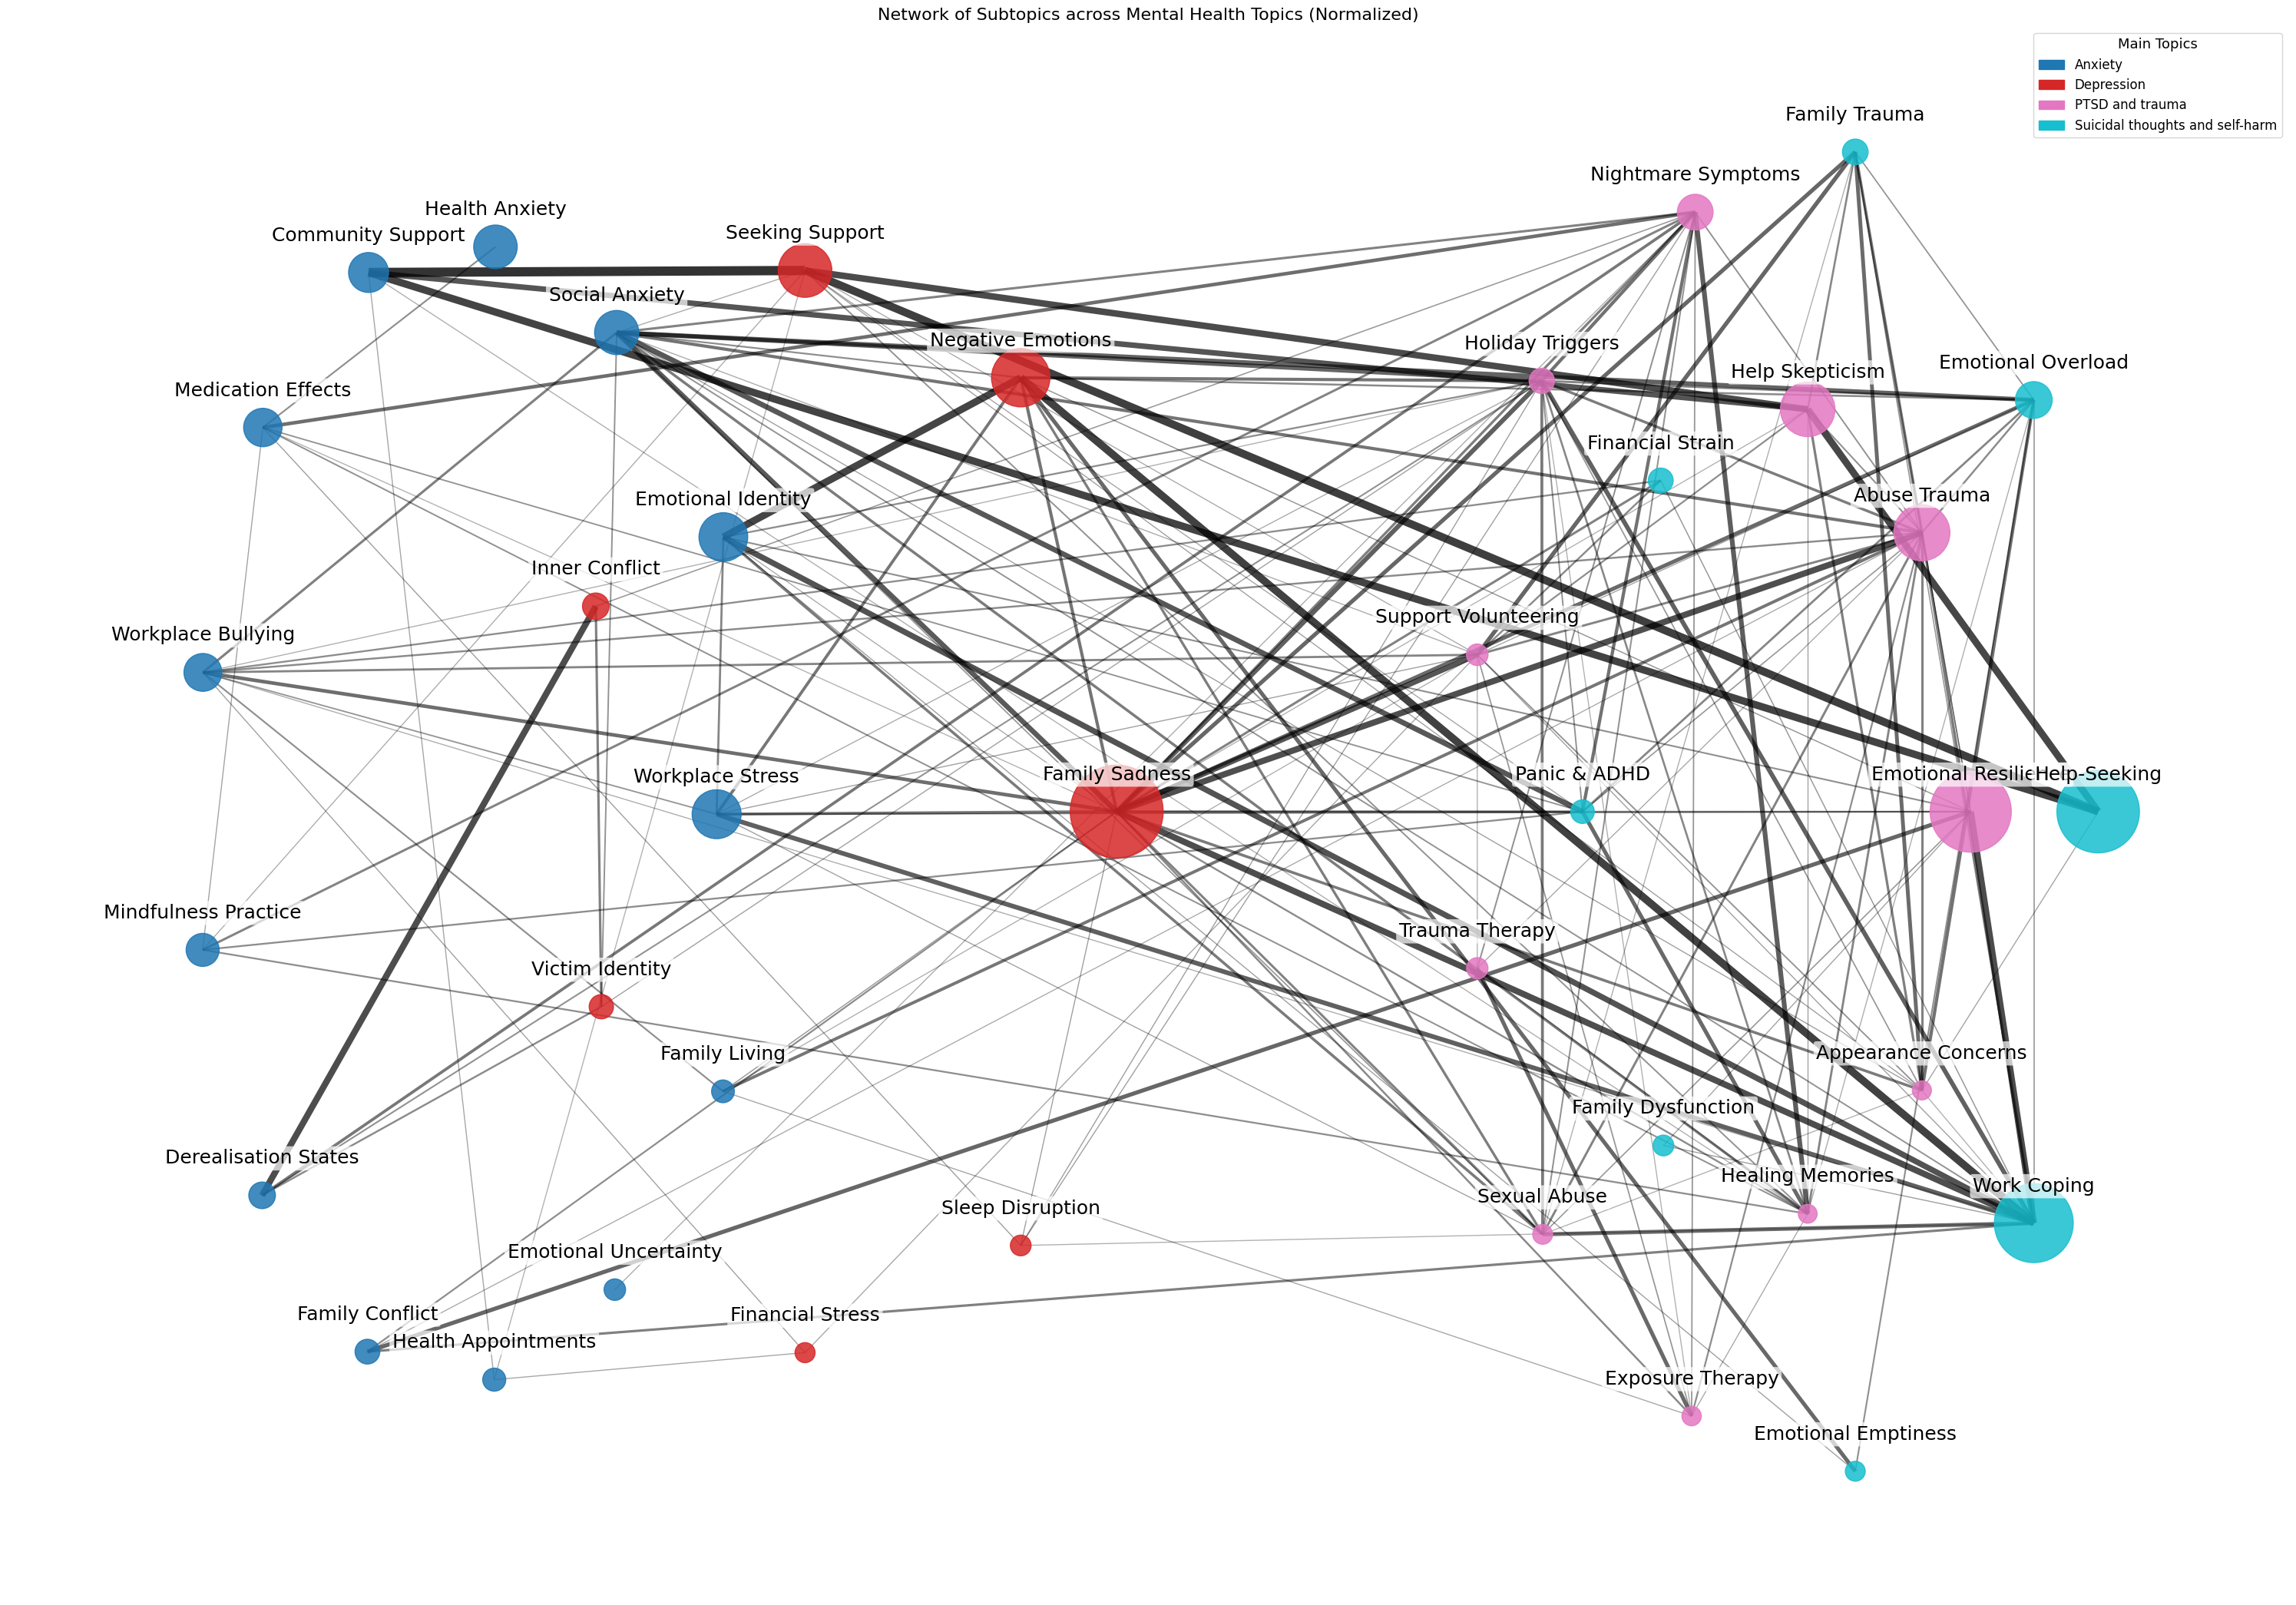

In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from bertopic import BERTopic
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict



def load_model_and_subtopics(platform, label, custom_names):
    """Load BERTopic model and subtopic info with topic embeddings."""
    path = os.path.join(os.getcwd(), 'data', f'{platform}_data', 'berttopic_label', label)
    try:
        topic_model = BERTopic.load(os.path.join(path, f'{label}_berttopic'))
    except Exception as e:
        print(f"Error loading model for label '{label}': {e}")
        return []
    
    # Get topic assignments and info
    topic_info = topic_model.get_topic_info()
    topic_keywords = {t: topic_model.get_topic(t) for t in topic_info.Topic if t != -1}
    doc_counts = topic_info.set_index("Topic")["Count"].to_dict()
    # Total number of documents assigned to this label (excluding outliers)
    total_label_docs = sum([count for tid, count in doc_counts.items() if tid != -1])
    
    
    # Get topic embeddings (excluding -1 if present)
    topic_embeddings = topic_model.topic_embeddings_
    topic_ids = sorted([t for t in topic_keywords.keys()])  # Only valid topics
    if len(topic_embeddings) != len(topic_info):
        print(f"Warning: Mismatch between topic embeddings ({len(topic_embeddings)}) and topics ({len(topic_info)}) for label '{label}'.")
    
    subtopics = []
    for topic_id in topic_ids:
        keywords = [(kw, score) for kw, score in topic_keywords[topic_id]]
        doc_indices = [i for i, t in enumerate(topic_model.topics_) if t == topic_id]
        if not doc_indices:
            print(f"Warning: No documents assigned to topic {topic_id} in label '{label}'.")
            continue
        # Map topic_id to embedding index (assuming embeddings align with topic IDs)
        embedding_idx = topic_id + 1 if topic_id >= 0 else 0  # Adjust for -1 if present
        if embedding_idx >= len(topic_embeddings):
            print(f"Warning: No embedding for topic {topic_id} in label '{label}'.")
            continue
        subtopics.append({
            'model_label': label,
            'topic_id': topic_id,
            'name': custom_names.get(topic_id, f"{label}_{topic_id}"),
            'keywords': keywords,
            'doc_indices': doc_indices,
            'doc_count': doc_counts.get(topic_id, 0),
            'embedding': topic_embeddings[embedding_idx],
            'total_label_docs': total_label_docs
        })
    
    return subtopics

def network_vis(platform, labels, custom_names_dict, sim_threshold=0.9):
    all_subtopics = []
    
    for label in labels:
        custom_names = custom_names_dict.get(label, {})
        subtopics = load_model_and_subtopics(platform, label, custom_names)
        if not subtopics:
            print(f"Skipping label '{label}' due to loading issues.")
            continue
        all_subtopics.extend(subtopics)
    
    if not all_subtopics:
        print("Error: No subtopics available for visualization.")
        return nx.Graph()
    
    embeddings = np.array([t['embedding'] for t in all_subtopics])
    sim_matrix = cosine_similarity(embeddings)
    




    G = nx.Graph()
    cmap = get_cmap("tab10", len(labels))
    label_color = {label: cmap(i) for i, label in enumerate(labels)}
    
    # Add nodes with normalized sizes
    for idx, topic in enumerate(all_subtopics):
        relative_size = topic['doc_count'] / topic['total_label_docs']
        G.add_node(
            idx,
            label=topic['model_label'],
            name=topic['name'],
            keywords=', '.join([kw for kw, _ in topic['keywords'][:5]]),
            size=relative_size,
            true_doc_count=topic['doc_count'],
            color=label_color[topic['model_label']],
        )
    


    # Add edges based on similarity
    min_sim, max_sim = np.inf, -np.inf
    for i in range(len(all_subtopics)):
        for j in range(i + 1, len(all_subtopics)):
            sim = sim_matrix[i, j]
            if sim >= sim_threshold:
                G.add_edge(i, j, weight=sim)
                min_sim = min(min_sim, sim)
                max_sim = max(max_sim, sim)
    






    # Graph layout clustering by main topic
    pos = {}
    horizontal_scale = 4  # horizontal separation
    vertical_scale = 4  # Scale vertical coordinates
    np.random.seed()  # For reproducible perturbations
    for i, label in enumerate(labels):
        nodes = [n for n, d in G.nodes(data=True) if d["label"] == label]
        subgraph = G.subgraph(nodes)
        # Dynamic offset based on number of nodes
        offset_step = 9.0 * (len(nodes) / 10.0)
        sub_pos = nx.circular_layout(subgraph, scale=1.0)
        
        for k in sub_pos:
            # Apply scaling for elliptical shape
            sub_pos[k][0] *= horizontal_scale
            sub_pos[k][1] *= vertical_scale
            sub_pos[k][0] += i * offset_step
        pos.update(sub_pos)






    def enforce_minimum_distance(pos, min_distance=2.5, max_iter=100):
        """Ensure nodes are at least `min_distance` apart."""
        for _ in range(max_iter):
            moved = False
            nodes = list(pos.keys())
            for i in range(len(nodes)):
                for j in range(i + 1, len(nodes)):
                    node_i, node_j = nodes[i], nodes[j]
                    xi, yi = pos[node_i]
                    xj, yj = pos[node_j]
                    dx, dy = xi - xj, yi - yj
                    dist = np.sqrt(dx ** 2 + dy ** 2)
                    if dist < min_distance and dist > 0:
                        # Move them apart
                        shift = (min_distance - dist) / 2
                        dx, dy = dx / dist * shift, dy / dist * shift
                        pos[node_i] = (xi + dx, yi + dy)
                        pos[node_j] = (xj - dx, yj - dy)
                        moved = True
            if not moved:
                break
        return pos

    # Apply minimum distance enforcement
    pos = enforce_minimum_distance(pos, min_distance=2)








    # Draw the graph
    plt.figure(figsize=(30, 21))
    
    node_sizes = [G.nodes[n]['size'] * 15000 for n in G.nodes]  # normalized & scaled
    node_colors = [G.nodes[n]['color'] for n in G.nodes]
    
    if G.edges:
        # # Normalize similarity
        # edge_weights = [((G[u][v]['weight'] - min_sim) / (max_sim - min_sim + 1e-6)) * 5 + 0.5 for u, v in G.edges]


        # Improved edge weight scaling
        edge_weights = [G[u][v]['weight'] for u, v in G.edges]
        # Scale weights to range [1, 10] with emphasis on higher similarities
        scaler = MinMaxScaler(feature_range=(1, 15))
        scaled_weights = scaler.fit_transform(np.array(edge_weights).reshape(-1, 1)).flatten()
        # Apply exponential scaling to emphasize differences near the threshold
        scaled_weights = [2.5 * (np.exp(w / 10) - 1) for w in scaled_weights]
        # Ensure minimum visibility and cap maximum width
        scaled_weights = [min(max(w, 1.0), 12.0) for w in scaled_weights]
        # Adjust alpha for edges based on similarity
        edge_alphas = [0.3 + 0.5 * ((w - min(edge_weights)) / (max(edge_weights) - min(edge_weights) + 1e-6)) for w in edge_weights]
        


    else:
        edge_weights = []
        edge_alphas = []

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.85)
    for (u, v), width, alpha in zip(G.edges, scaled_weights, edge_alphas):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, alpha=alpha)
    # nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.4)




    for node, (x, y) in pos.items():
        plt.text(
            x, y + 0.2,  # Shift upward
            G.nodes[node]['name'],
            fontsize=18,
            ha='center',
            va='bottom',
            color='black',
            bbox=dict(boxstyle='round,pad=0.15', fc='white', ec='none', alpha=0.7)
        )
    
    
    # for node, (x, y) in pos.items():
    #     plt.text(x, y - 0.2,
    #             f"{G.nodes[node]['true_doc_count']}",
    #             fontsize=20,
    #             ha='center',
    #             color='black',
    #             bbox=dict(boxstyle='round,pad=0.1', fc='white', ec='none', alpha=0.6))

    legend_handles = [
        mpatches.Patch(color=label_color[label], label=label)
        for label in labels
    ]
    plt.legend(
        handles=legend_handles,
        loc="upper right",
        fontsize=12,
        title="Main Topics",
        title_fontsize=13
    )

    plt.title("Network of Subtopics across Mental Health Topics (Normalized)", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    return G



# Run the visualization
platform = "beyondblue"
labels = ["Anxiety", "Depression","PTSD and trauma", "Suicidal thoughts and self-harm"]
G = network_vis(platform, labels, custom_names_dict, sim_threshold=0.9915)


Regression model 

line plot for whole main topics 

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns


current_dir = os.getcwd()
platform = "beyondblue"
labels = ["Anxiety", "Depression", "PTSD and trauma", "Suicidal thoughts and self-harm"]


main_symptoms_df = []
for label in labels:
    df = pd.read_csv(os.path.join(current_dir, 'data',f'{platform}_data','berttopic_label',f'{label}','label_df.csv'))
    main_symptoms_df.append(df)

main_symptoms_df = pd.concat(main_symptoms_df, ignore_index=True)
main_symptoms_df['year'] = pd.to_datetime(main_symptoms_df['Post Date']).dt.year
main_symptoms_df['Post Category'] = main_symptoms_df['Post Category'].str.strip()

print(main_symptoms_df.shape)
# check how many missing value in the year column
print("Missing values in 'year' column:", main_symptoms_df['year'].isna().sum())






# Group and count number of posts per year per category
post_counts = main_symptoms_df.groupby(['year', 'Post Category']).size().reset_index(name='Post Count')

# Now plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=post_counts, x='year', y='Post Count', hue='Post Category', marker='o')
plt.title('Number of Posts by Year and Post Category')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.legend(title='Post Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

line plot for  subtopics for each main topics

C:\Users\user\AppData\Local\Temp\ipykernel_29672\1613755513.py:82: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['year'] = pd.to_datetime(df['Post Date']).dt.year


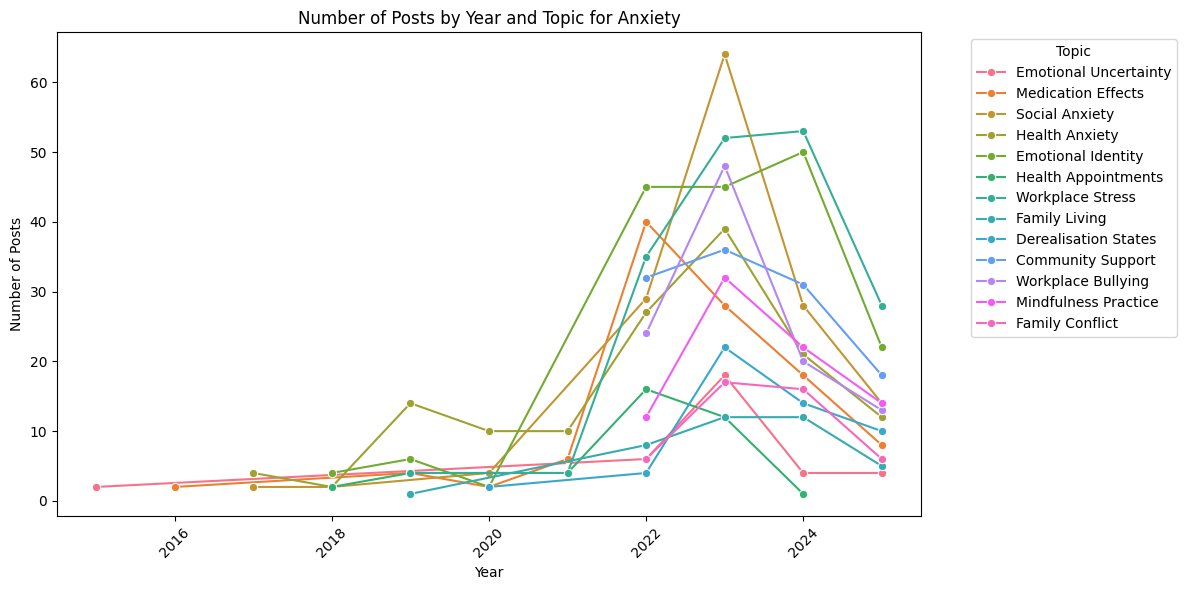

C:\Users\user\AppData\Local\Temp\ipykernel_29672\1613755513.py:82: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['year'] = pd.to_datetime(df['Post Date']).dt.year


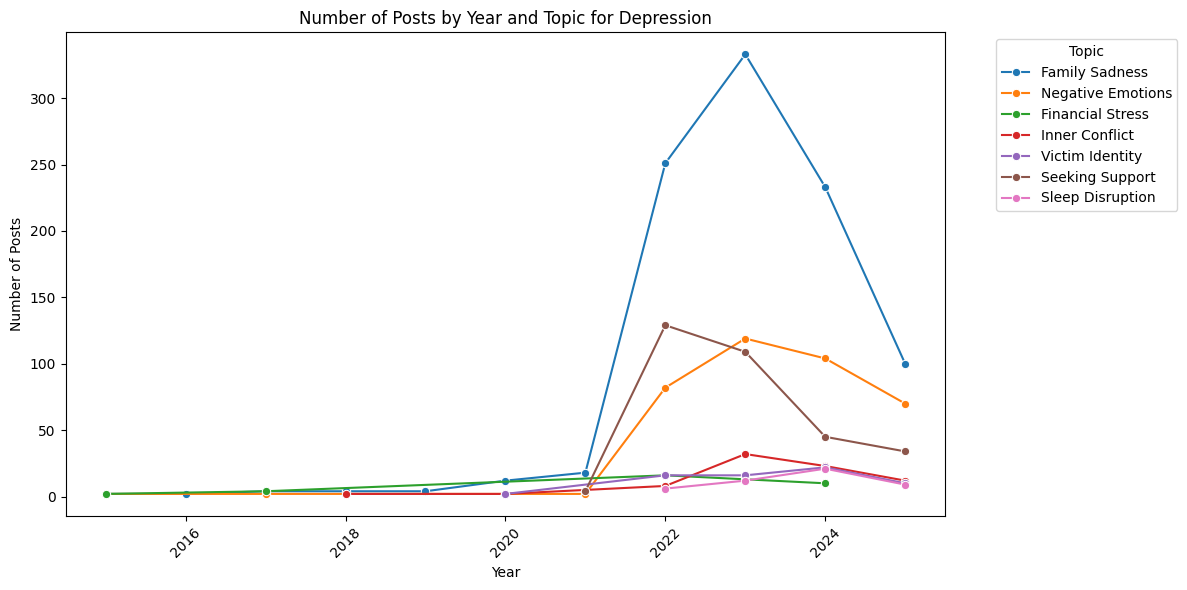

C:\Users\user\AppData\Local\Temp\ipykernel_29672\1613755513.py:82: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['year'] = pd.to_datetime(df['Post Date']).dt.year


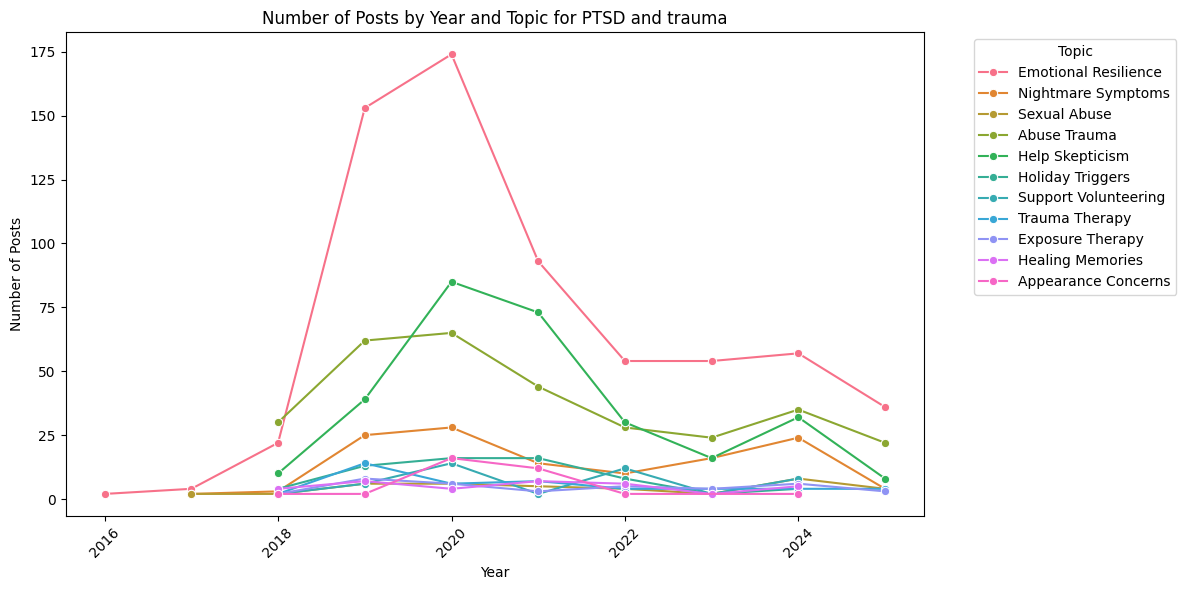

C:\Users\user\AppData\Local\Temp\ipykernel_29672\1613755513.py:82: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['year'] = pd.to_datetime(df['Post Date']).dt.year


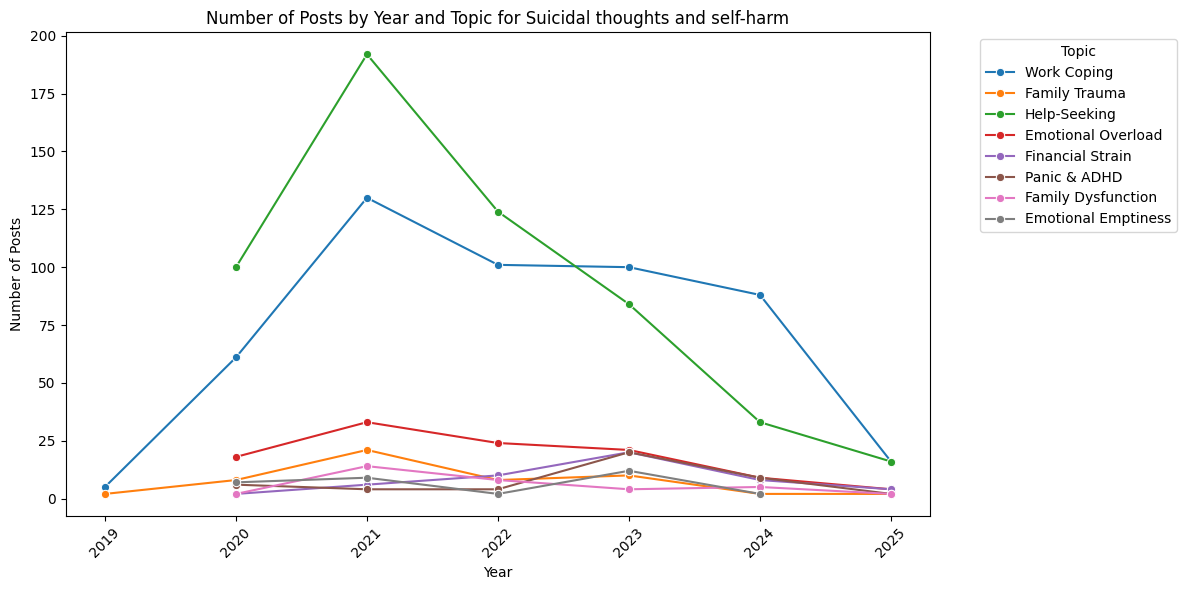

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns



current_dir = os.getcwd()
platform = "beyondblue"
labels = ["Anxiety", "Depression", "PTSD and trauma", "Suicidal thoughts and self-harm"]



for label in labels:
    df = pd.read_csv(os.path.join(current_dir, 'data',f'{platform}_data','berttopic_label',f'{label}',f'{label}_topic_docs.csv'))

    # draw the line plot according to the number of posts for each topic(custome topic) by year excludinf -1 topic
    df['year'] = pd.to_datetime(df['Post Date']).dt.year
    df = df[df['Topic'] != -1]  # Exclude outliers
    topic_counts = df.groupby(['year', 'Topic']).size().reset_index(name='Post Count')
    topic_counts['Topic'] = topic_counts['Topic'].replace(custom_names_dict[label])
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=topic_counts, x='year', y='Post Count', hue='Topic', marker='o')
    plt.title(f'Number of Posts by Year and Topic for {label}')
    plt.xlabel('Year')
    plt.ylabel('Number of Posts')
    plt.xticks(rotation=45)
    plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # plt.savefig(os.path.join(current_dir, 'data', f'{platform}_data', 'berttopic_label', f'{label}', f'{label}_topic_yearly_counts.png'))
    plt.show()
    
    

    